In [1]:
import pandas as pd
import re
pd.set_option('max_colwidth', 50)


The Health Department has developed an inspection report and scoring system. 
After conducting an inspection of the facility, the Health Inspector calculates a score based on the violations observed. 
Violations can fall into:
- **high risk category**: records specific violations that directly relate to the transmission of food borne illnesses,the adulteration of food products and the contamination of food-contact surfaces.
- **moderate risk category**: records specific violations that are of a moderate risk to the public health and safety.
- **low risk category**: records violations that are low risk or have no immediate risk to the public health and safety.

In [2]:
businesses = pd.read_csv('data/businesses_plus.csv', parse_dates=True, dtype={'phone_number': str})
inspections = pd.read_csv('./data/inspections_plus.csv', parse_dates=True)
violations = pd.read_csv('./data/violations_plus.csv', parse_dates=True)

# Quirks with data

# there are small amounts of duplicates in the tables, I will remove.
dups_before_drop = len(businesses) + len(inspections) + len(violations)
businesses = businesses.drop_duplicates(subset='business_id')
inspections = inspections.drop_duplicates()
violations = violations.drop_duplicates()
current_len = len(businesses) + len(inspections) + len(violations)
print("duplicates: {}".format(dups_before_drop - current_len))

# there are ~1600 businesses that don't have inspections/violation data
# reassign/ remove --> businesses_no_dup[~businesses_no_dup.business_id.isin(inspections_no_dup.business_id)]
diff = len(businesses) - inspections.business_id.nunique()
print("Businesses with no inspection data: {}".format(diff))

# there are some inspections that refer to businesses not in the businesses table
diff = list(set(inspections.business_id).difference(set(businesses.business_id)))
print("Inspections for businesses not listed in business table: {}".format(len(diff)))

# there are some violations that refer to businesses not in the business table either
diff = list(set(violations.business_id).difference(set(businesses.business_id)))
print("Violations for businesses not listing in business table: {}".format(len(diff)))

#there are ~900 inspections that do not have violations

#e.g. Starbucks is counted in many different ways - standardize names
# fix a few of the most egregious ones
businesses.name.fillna('NA', inplace=True)
businesses.name = businesses.name.apply(lambda x: str(x).lower())
print("Unique forms of 'starbucks' name in data: {}".format(businesses.name[businesses.name.str.contains('starbuck')].nunique()))

patternr = "starbuck|peet|subway|mcdon|philz|phil'z"
patternd = {
    "starbuck": "starbucks",
    "peet": "peet's coffee", 
    "subway": "subway", 
    "mcdon": "mcdonald's",
    "philz": "philz coffee",
    "phil'z": "philz coffee"
}
biz_to_change = businesses[businesses.name.str.contains(patternr)].index
biz_name = businesses[businesses.index.isin(biz_to_change)].name
bizs = zip(biz_to_change, biz_name)
for index, biz in bizs:
    match = re.match(patternr, biz)
    if match:
        businesses.loc[index, 'name'] = patternd[match.group(0)]


duplicates: 244
Businesses with no inspection data: 1572
Inspections for businesses not listed in business table: 28
Violations for businesses not listing in business table: 19
Unique forms of 'starbucks' name in data: 32


In [3]:
# 1 Combine the three dataframes into one data frame called restaurant_scores
# Hint: http://pandas.pydata.org/pandas-docs/stable/merging.html

# NOTE 
# SQL duplication issue (re-using same keys accross all 3 tables/ frames)
# Will need better solution than simple merging such as:

restaurant_scores = businesses.merge(inspections, on='business_id') \
.merge(violations, on=['business_id', 'date'])

print("restaurant_scores 1: {}".format(restaurant_scores.shape))
print("\n ** SPECIAL CONSIDERATION FOR JOIN DOUBLE COUNTING **\n")

# Let's make a new key shared by inspections & violations, based on date - business_id relationship:

new_id_col = zip(inspections.business_id, inspections.date)
new_id_col = [str(x) + '-' + str(y) for x,y in new_id_col]                  
inspections['inspection_id'] = new_id_col

#same in violations

new_id_col = zip(violations.business_id, violations.date)
new_id_col = [str(x) + '-' + str(y) for x,y in new_id_col]  
violations['inspection_id'] = new_id_col
violations = violations.drop('business_id', 1) #
violations = violations.drop('date', 1)

# We need to account for multi counting due to the join .e.g my new inspection_id == '72004-20130913' 
# shows how all entries in violates for same inspection with multiple:

rests = businesses.merge(inspections, on='business_id').merge(violations, on='inspection_id')
len(rests[rests.inspection_id == '3016-20131218']) # 33
len(inspections[inspections.inspection_id == '3016-20131218']) # 3
len(violations[violations.inspection_id == '3016-20131218']) # 11
# only should could 11 violations here not 33... 

# drop violations dups
rests = rests.drop_duplicates(subset=['inspection_id', 'ViolationTypeID', 'risk_category', 'description']) #violations identifers
restaurant_scores = rests

print("restaurant_scores better: {}".format(restaurant_scores.shape))            
            
            



restaurant_scores 1: (43486, 22)

 ** SPECIAL CONSIDERATION FOR JOIN DOUBLE COUNTING **

restaurant_scores better: (39449, 23)


In [6]:
# 2 Which ten business have had the most inspections?

#Use name, not business_id because multiple locations
#Don't use full restaurants frame or will count violations

#e.g. Starbucks is counted in many different ways - standardize names
# do a few of the major ones

merged = businesses.merge(inspections)
merged.name.value_counts()
restaurant_scores.name.value_counts().head(10)


starbucks                    253
subway                       204
peet's coffee                179
mcdonald's                    65
lee's deli                    63
cafe bakery                   59
lers ros thai noodle          59
specialty's cafe & bakery     59
kentucky fried chicken        59
happy donut                   55
Name: name, dtype: int64

In [5]:
# 3 Group and count the inspections by type

inspections.type.value_counts()


Routine - Unscheduled                15481
Reinspection/Followup                 5327
New Ownership                         1861
Complaint                             1594
New Construction                      1581
Non-inspection site visit              827
Complaint Reinspection/Followup        161
Structural Inspection                  120
Foodborne Illness Investigation         98
Routine - Scheduled                     63
Administrative or Document Review        4
Special Event                            2
Multi-agency Investigation               2
Name: type, dtype: int64

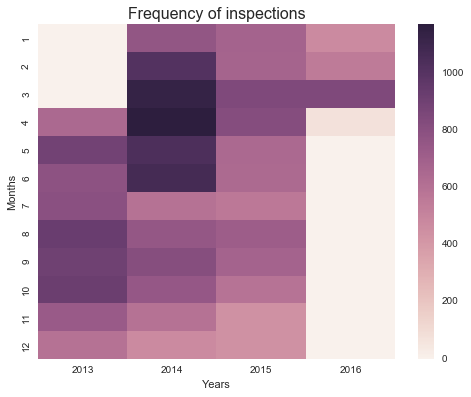

In [81]:
# 4 Create a plot that shows number of inspections per month
# Bonus for creating a heatmap
# http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.heatmap.html?highlight=heatmap
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dateutil
%matplotlib inline

inspections2 = inspections #could get messy
inspections['month'] = [int(str(x)[4:6]) for x in inspections['date']]
inspections2['year'] = [int(str(x)[:4]) for x in inspections2['date']]

def get_freq_count_at_year_month(month, year):
    return inspections2[(inspections2.month == month) & (inspections2.year == year)].count().values[0]

#new DF to represent counts in given year-month
counts_df = pd.DataFrame(np.zeros((48,3), dtype=np.int), columns=['month', 'year', 'freq_count'])

months = range(1,13)*4
years = [2013]*12 + [2014]*12 + [2015]*12 + [2016]*12
for i in range(0,48):
    month = months[i]
    year = years[i]
    freq_count = get_freq_count_at_year_month(month, year)
    counts_df.loc[i] = [month, year, freq_count]    

counts_df = counts_df.pivot('month', 'year', 'freq_count')

plt = sns.heatmap(counts_df)
plt.set_title('Frequency of inspections', fontsize=16)
plt.set_xlabel("Years")
plt.set_ylabel("Months")
plt.figure.set_size_inches(8,6)

# It's alive!

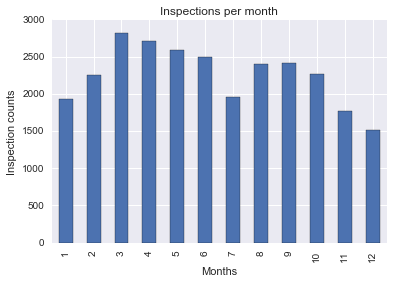

In [77]:
#matplotlib
inspections.groupby('month').size().plot(kind="bar", title="Inspections per month") #groupby & size b/c 1-12 order
plt.xlabel('Months')
plt.ylabel('Inspection counts')



In [181]:
# 5 Which zip code contains the most high risk violations?


high_risk_zips = restaurant_scores[restaurant_scores.risk_category == 'High Risk'] \
  .groupby('postal_code').size()
    
high_risk_zips.sort_values(ascending=False)[:5]


postal_code
94133    529
94110    494
94103    494
94109    396
94102    388
dtype: int64

In [203]:
# 6 If inspection is prompted by a change in restaurant ownership, 
# is the inspection more likely to be categorized as higher or lower risk?

risk_dist = restaurant_scores[restaurant_scores.type == 'New Ownership'].risk_category.value_counts(normalize=True)

print("Chance high risk: {:.2f}%, chance low risk: {:.2f}%".format(risk_dist[2]*100, risk_dist[0]*100))


Chance high risk: 13.97%, chance low risk: 50.44%


In [213]:
# 7 Examining the descriptions, what is the most common violation?

violations.description.value_counts()[:1]

Unclean or degraded floors walls or ceilings    3391
Name: description, dtype: int64

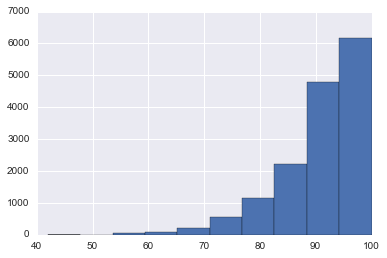

In [266]:
# 8 Create a hist of the scores with 10 bins

inspections.Score.hist(bins=10)


/Users/richfisher/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



 Latitude - Longitude predictive % without much KNN tuning: 
56.17%



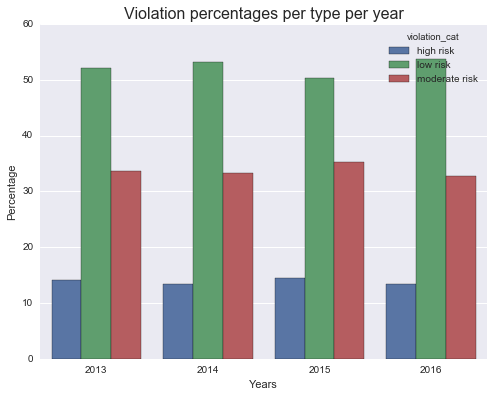

In [1004]:
# 9 Can you predict risk category based on the other features in this dataset?
rs = restaurant_scores

# For z-score purposes, risk category distribution of population 
violations.risk_category.value_counts(normalize=True)*100
# Low Risk - 52.2%
# Moderate Risk - 33.9%
# High Risk - 13.9%

def get_risk_percentage_arr(risk_counts_2d_arr):
    risk_percentage_arr = []
    for counts in risk_counts_2d_arr:
        total = float(sum(counts)) 
        for x in counts:
            risk_percentage_arr.append(float(x)/total *100)
    return risk_percentage_arr       

# Could predict based on top owners in city
# Looking at top 10
rs[rs.name.isin(rs.name.value_counts()[:10].index)].groupby(['name', 'risk_category']).size()
# e.g. Starbucks has a 69.2% (175/253 low risk) of getting low risk vs. the 52.2% avg
# Apparently being a top franchise like Starbucks, Subway, or Peets puts you at *lower* risk


############


# Could predict based on dates... maybe regulations or grading standards changed.
rs['year'] = [str(x)[0:4] for x in rs.date]
values = rs.groupby(['year', 'risk_category']).size().values
yr_2013, yr_2014, yr_2015, yr_2016 = values[:3], values[3:6], values[6:9], values[9:]

risk_cat_dists_by_year = get_risk_percentage_arr([yr_2013, yr_2014, yr_2015, yr_2016])
years = [2013]*3 + [2014]*3 + [2015]*3 + [2016]*3
cats = ['high risk', 'low risk', 'moderate risk']*4
risk_by_year = zip(years, cats, risk_cat_dists_by_year)

risks_df = pd.DataFrame(risk_by_year, columns=['year', 'violation_cat', 'percent_violations_issued'])
risks_df.head(3)
plt = sns.barplot(data=risks_df, x="year", y="percent_violations_issued", hue='violation_cat')
plt.set_title('Violation percentages per type per year', fontsize=16)
plt.set_xlabel("Years")
plt.set_ylabel("Percentage")
plt.figure.set_size_inches(8,6)

# not a good predictor - pretty consistent accross years! 


############


# Could look at lat-long areas/ geo-fencing
# Look at the 'scene', like Polk Gultch vs. Hayes Valley  
# This could be investigated with K Nearest Neighbors 

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10) 

rs = rs.dropna(subset=['risk_category', 'latitude', 'longitude'])
int_mapping = {'High Risk': 2, 'Moderate Risk': 1, 'Low Risk': 0}

rs['risk_category_int'] = [int_mapping[x] for x in rs.risk_category]
X = rs[['latitude', 'longitude']]
y = rs.risk_category_int

knn.fit(X, y)        
prediction = knn.score(X, y)
print("\n Latitude - Longitude predictive % without much KNN tuning: \n{:.2f}%\n".format(prediction*100))

#at 56% without much tuning, the lat-long is a slight improvement over blindly picking 'low risk' every time

In [4]:
# 10 Extra Credit:
# Use Instagram location API to find pictures taken at the lat, long of the most High Risk restaurant
# https://www.instagram.com/developer/endpoints/locations/

# NOTE - pretty sure in sandbox mode there are now limitations that make it hard to get media without 
# registering those users with app. Can get metadata but not images.

import requests
import json

rs = restaurant_scores
rs[rs.risk_category == 'High Risk'].groupby(["business_id", 'risk_category']).size() \
  .sort_values(ascending=False)[:1]
latitude = rs[rs.business_id == 33446][:1].latitude.values[0]
longitude = rs[rs.business_id == 33446][:1].longitude.values[0]

#https://api.instagram.com/oauth/authorize/?client_id=xXxXx&redirect_uri=http://thewebapp.dev/
#  &response_type=token&scope=public_content

#curl -F 'client_id=XXX' -F 'client_secret=XXX' -F 'grant_type=authorization_code' 
#  -F 'redirect_uri=http://google.com' -F 'code=87b63f15742b4e57a013679a85404677' 
#  https://api.instagram.com/oauth/access_token

access_token = "3798722982.726f657.bec6e4af3b1a421c8f13150eac2715f3"

locations_base = "https://api.instagram.com/v1/locations/"
location_search_url = "search?"
lat_p = "&lat=" + str(latitude)
long_p = "&lng=" + str(longitude)
access_p = "&access_token=" + access_token

response = requests.get(locations_base + location_search_url + lat_p + long_p + access_p)
json.loads(response.text)["data"]
location_ids = []
for location in json.loads(response.text)["data"]:
    location_ids.append(location["id"])
#returns a bunch of IDs 


locations_recent_media = "/media/recent?access_token=" + access_token
resps = []
for id in location_ids:    
    response = requests.get(locations_base + str(id) + locations_recent_media + "&distance=5000")
    resps.append(response.text)
resps
# returns a bunch of {"pagination": {}, "meta": {"code": 200}, "data": []}
# I believe this is because the sandbox mode of API is blocking actual media
  # In Sandbox mode I'm pretty sure have to explicitly register the users whose media you want with your app




[u'{"pagination": {}, "meta": {"code": 200}, "data": []}',
 u'{"pagination": {}, "meta": {"code": 200}, "data": []}',
 u'{"pagination": {}, "meta": {"code": 200}, "data": []}',
 u'{"pagination": {}, "meta": {"code": 200}, "data": []}',
 u'{"pagination": {}, "meta": {"code": 200}, "data": []}',
 u'{"pagination": {}, "meta": {"code": 200}, "data": []}',
 u'{"pagination": {}, "meta": {"code": 200}, "data": []}',
 u'{"pagination": {}, "meta": {"code": 200}, "data": []}',
 u'{"pagination": {}, "meta": {"code": 200}, "data": []}',
 u'{"pagination": {}, "meta": {"code": 200}, "data": []}',
 u'{"pagination": {}, "meta": {"code": 200}, "data": []}',
 u'{"pagination": {}, "meta": {"code": 200}, "data": []}',
 u'{"pagination": {}, "meta": {"code": 200}, "data": []}',
 u'{"pagination": {}, "meta": {"code": 200}, "data": []}',
 u'{"pagination": {}, "meta": {"code": 200}, "data": []}',
 u'{"pagination": {}, "meta": {"code": 200}, "data": []}',
 u'{"pagination": {}, "meta": {"code": 200}, "data": []}

In [ ]:
media_search_base = "https://api.instagram.com/v1/media/search

In [ ]:
############################
### A Little More Morbid ###
############################

In [788]:
killings = pd.read_csv('data/police-killings.csv')
killings = killings.drop('Unnamed: 0', 1)

killings['date'] = killings.month + '-' + killings.day.astype(str) + '-' + killings.year.astype(str)
killings.date = pd.to_datetime(killings.date, format='%B-%d-%Y')
killings = killings.drop(['month', 'day', 'year'],1)
killings[:1]



,name,age,gender,raceethnicity,streetaddress,city,state,lawenforcementagency,cause,armed,county_income,date
0,A'donte Washington,16,Male,Black,Clearview Ln,Millbrook,AL,Millbrook Police Department,Gunshot,No,54766,2015-02-23


In [767]:
# 1. Make the following changed to column names:
# lawenforcementagency -> agency
# raceethnicity        -> race

killings.rename(columns={"lawenforcementagency":"agency", "raceethnicity":"race"}, inplace=True)
killings[:1]

,name,age,gender,race,streetaddress,city,state,agency,cause,armed,county_income,date
0,A'donte Washington,16,Male,Black,Clearview Ln,Millbrook,AL,Millbrook Police Department,Gunshot,No,54766,2015-02-23


In [768]:
# 2. Show the count of missing values in each column

killings.isnull().sum()

name             0
age              0
gender           0
race             0
streetaddress    4
city             0
state            0
agency           0
cause            0
armed            0
county_income    0
date             0
dtype: int64

In [769]:
# 3. replace each null value in the dataframe with the string "Unknown"

killings[killings.isnull().any(axis=1)]
killings = killings.fillna("Unknown")
killings.isnull().any().any()

False

In [770]:
# 4. How many killings were there so far in 2015?

import datetime

start_2015 = datetime.date(year=2015,month=1,day=1)

len(killings[killings.date > start_2015])

464

In [771]:
# 5. Of all killings, how many were male and how many female?

killings.gender.value_counts()


Male      445
Female     22
Name: gender, dtype: int64

In [772]:
# 6. How many killings were of unarmed people?
killings.armed.value_counts()

no_counts = len(killings[killings.armed == "No"])
margin_others = len(killings[killings.armed.isin(["Other", "Unknown", "Disputed"])])

print("'No' in data: {}, with up to {} more as possible Other/Unknown".format(no_counts, margin_others))


'No' in data: 102, with up to 35 more as possible Other/Unknown


In [774]:
# 7. What percentage of all killings were unarmed?

for_no = killings.armed.value_counts(normalize=True)[1] * 100
for_unknown_disupted_other = sum([(killings.armed.value_counts(normalize=True)[x] * 100) for x in [6,7,3]])
print("{:.2f}% - {:.2f}% due to other,unknown,disputed".format(for_no, for_unknown_disupted_other+for_no))



21.84% - 29.34% due to other,unknown,disputed


In [775]:
# 8. What are the 5 states with the most killings?

killings.state.value_counts()[:5]

CA    74
TX    46
FL    29
AZ    25
OK    22
Name: state, dtype: int64

In [776]:
# 9. Show a value counts of deaths for each race

killings.race.value_counts()

White                     236
Black                     135
Hispanic/Latino            67
Unknown                    15
Asian/Pacific Islander     10
Native American             4
Name: race, dtype: int64

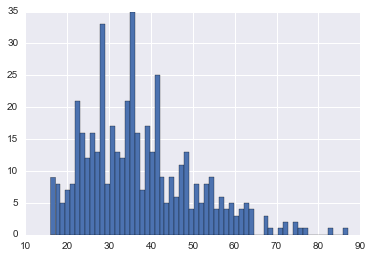

In [777]:
# 10. Display a histogram of ages of all killings

killings.age.hist(bins=killings.age.nunique())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x16e9f6d50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1702b3e50>]], dtype=object)

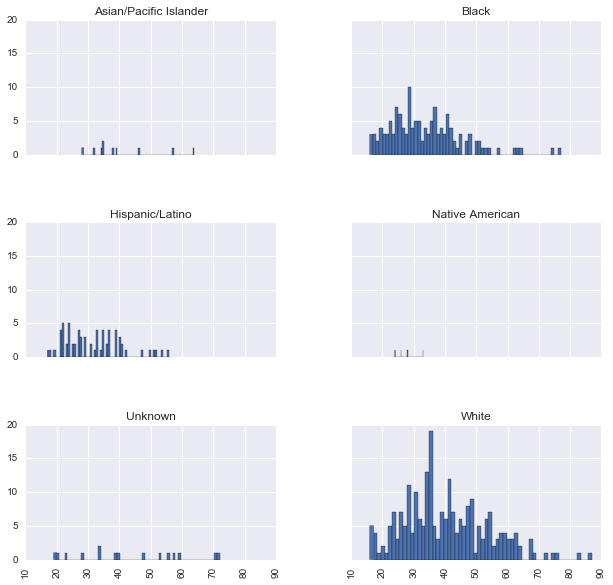

In [995]:
# 11. Show 6 histograms of ages by race

killings.age.hist(by=killings.race,sharex=True, sharey=True, bins=killings.age.nunique(), figsize=(10,10))

In [779]:
# 12. What is the average age of death by race?

killings.groupby('race').age.mean()


race
Asian/Pacific Islander    40.800000
Black                     34.044444
Hispanic/Latino           31.716418
Native American           27.750000
Unknown                   43.533333
White                     40.466102
Name: age, dtype: float64

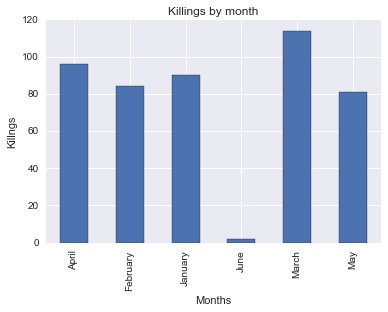

In [797]:
# 13. Show a bar chart with counts of deaths every month

months_names = [x.strftime("%B") for x in killings.date]
killings['month'] = months_names

plot = killings.groupby("month").size().plot(kind='bar', title='Killings by month')
plot.set_xlabel("Months")
plot.set_ylabel("Killngs")

In [ ]:
###################
### Less Morbid ###
###################

In [465]:
majors = pd.read_csv('data/college-majors.csv')

majors.columns = [x.lower() for x in majors.columns]
majors[:1]

majors.rename(columns={'median':'medianx'}, inplace=True) #name conflict .notation

In [466]:
# 1. Delete the columns (employed_full_time_year_round, major_code)

del majors['unnamed: 0']
del majors['employed_full_time_year_round']
del majors['major_code']


In [467]:
# 2. Show the cout of missing values in each column

majors.isnull().sum()

major                0
major_category       0
total                0
employed             0
unemployed           0
unemployment_rate    0
medianx              0
p25th                0
p75th                0
dtype: int64

In [791]:
# 3. What are the top 10 highest paying majors?
base = majors[['major', 'medianx', 'p25th', 'p75th']] 
metrics = []
for metric in ['medianx', 'p25th', 'p75th']:    
    metrics.append(base.sort_values(by=metric, ascending=False)[:10].major.values)

md = set(metrics[0])
p25 = set(metrics[1])
p75 = set(metrics[2])

#( md | p25 | p75)
majors_in_all_cats = (md & p25 & p75)
other3 = p75 - (md & p25 & p75)

print("7 majors shared in top 10 for each of median, p25 & p75: \n{}\n".format(" *** ".join(majors_in_all_cats)))
print("other top 3 majors in p75: \n{}".format(" *** ".join(other3)))

7 majors shared in top 10 for each of median, p25 & p75: 
PHARMACY PHARMACEUTICAL SCIENCES AND ADMINISTRATION *** NAVAL ARCHITECTURE AND MARINE ENGINEERING *** METALLURGICAL ENGINEERING *** NUCLEAR ENGINEERING *** CHEMICAL ENGINEERING *** ELECTRICAL ENGINEERING *** PETROLEUM ENGINEERING

other top 3 majors in p75: 
MATHEMATICS AND COMPUTER SCIENCE *** GEOLOGICAL AND GEOPHYSICAL ENGINEERING *** MINING AND MINERAL ENGINEERING


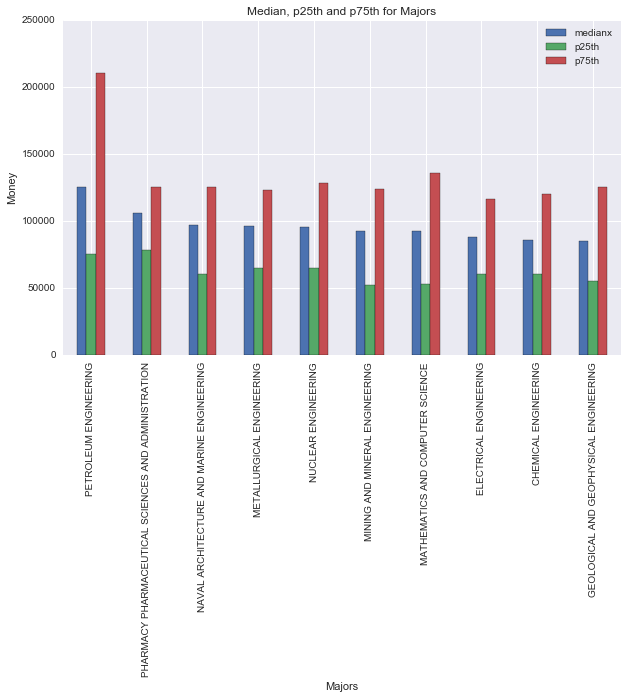

In [569]:
# 4. Plot the data from the last question in a bar chart, include proper title, and labels!

plot = majors[['major', 'medianx', 'p25th', 'p75th']].sort_values(by='medianx', ascending=False)[:10] \
  .plot(kind='bar', title="Median, p25th and p75th for Majors", x='major', figsize=(10,6))
plot.set_xlabel("Majors")
plot.set_ylabel("Money")

In [604]:
# 5. What is the average median salary for each major category?

majors.groupby("major_category").medianx.mean()

major_category
Agriculture & Natural Resources        55000.000000
Arts                                   43525.000000
Biology & Life Science                 50821.428571
Business                               60615.384615
Communications & Journalism            49500.000000
Computers & Mathematics                66272.727273
Education                              43831.250000
Engineering                            77758.620690
Health                                 56458.333333
Humanities & Liberal Arts              46080.000000
Industrial Arts & Consumer Services    52642.857143
Interdisciplinary                      43000.000000
Law & Public Policy                    52800.000000
Physical Sciences                      62400.000000
Psychology & Social Work               44555.555556
Social Science                         53222.222222
Name: medianx, dtype: float64

In [609]:
# 6. Show only the top 5 paying major categories
majors.groupby("major_category").medianx.mean().sort_values(ascending=False)[:5]


major_category
Engineering                77758.620690
Computers & Mathematics    66272.727273
Physical Sciences          62400.000000
Business                   60615.384615
Health                     56458.333333
Name: medianx, dtype: float64

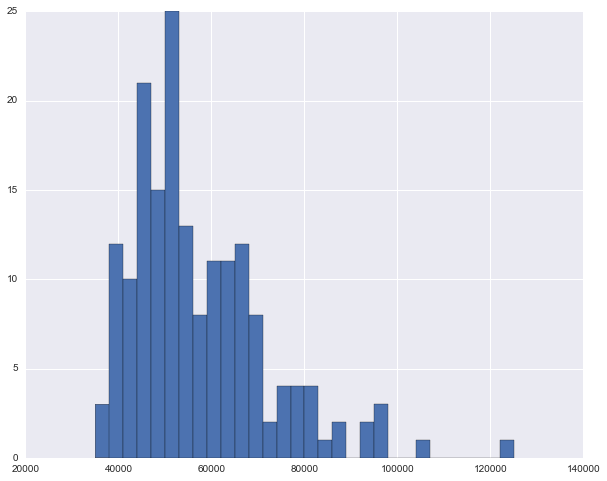

In [651]:
# 7. Plot a histogram of the distribution of median salaries

majors.medianx.hist(bins=30,figsize=(10,8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x16fd59610>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x16d05a590>]], dtype=object)

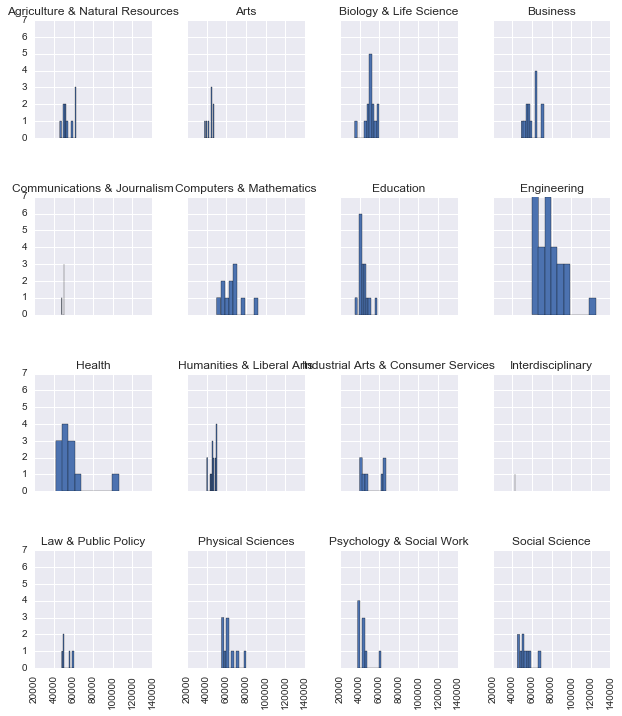

In [792]:
# 8. Plot a histogram of the distribution of median salaries by major category

majors.medianx.hist(by=majors.major_category, sharex=True, sharey=True, figsize=(10,12))


In [712]:
# 9. What are the top 10 most UNemployed majors?

# NOTE
# Could be misleaing since the unemployed figures dont reflect the total populations & the employed figures


#majors.sort_values(by='unemployment_rate', ascending=False)[['major', 'unemployment_rate']][:10]
majors.sort_values(by='unemployed', ascending=False)[['major', 'unemployed']][:10]


,major,unemployed
161,BUSINESS MANAGEMENT AND ADMINISTRATION,147261
158,GENERAL BUSINESS,85626
114,PSYCHOLOGY,79066
159,ACCOUNTING,75379
13,COMMUNICATIONS,54390
73,ENGLISH LANGUAGE AND LITERATURE,52248
164,MARKETING AND MARKETING RESEARCH,51839
132,POLITICAL SCIENCE AND GOVERNMENT,40376
25,GENERAL EDUCATION,38742
78,BIOLOGY,36757


In [715]:
# What are the unemployment rates?

majors.sort_values(by='unemployed', ascending=False)[['major', 'unemployed', 'unemployment_rate']][:10]


,major,unemployed,unemployment_rate
161,BUSINESS MANAGEMENT AND ADMINISTRATION,147261,0.058865
158,GENERAL BUSINESS,85626,0.051378
114,PSYCHOLOGY,79066,0.069667
159,ACCOUNTING,75379,0.053415
13,COMMUNICATIONS,54390,0.064360
73,ENGLISH LANGUAGE AND LITERATURE,52248,0.068645
164,MARKETING AND MARKETING RESEARCH,51839,0.055033
132,POLITICAL SCIENCE AND GOVERNMENT,40376,0.069374
25,GENERAL EDUCATION,38742,0.043904
78,BIOLOGY,36757,0.059301


In [748]:
# 10. What are the top 10 most UNemployed majors CATEGORIES? Use the mean for each category
# What are the unemployment rates?

majors.groupby("major_category").unemployed.mean().sort_values(ascending=False)[:10]


major_category
Business                       33415.153846
Communications & Journalism    25299.750000
Social Science                 14683.333333
Arts                           13015.625000
Humanities & Liberal Arts      11942.400000
Psychology & Social Work       11578.444444
Law & Public Policy             8609.800000
Education                       7833.500000
Computers & Mathematics         7270.363636
Health                          6251.083333
Name: unemployed, dtype: float64

In [759]:
# 11. the total and employed column refer to the people that were surveyed.
# Create a new column showing the emlpoyment rate of the people surveyed for each major
# call it "sample_employment_rate"
# Example the first row has total: 128148 and employed: 90245. it's 
# sample_employment_rate should be 90245.0 / 128148.0 = .7042


majors.total.dtype == np.int64
majors.employed.dtype == np.int64
majors['sample_employment_rate'] = majors.employed / majors.total
majors[:1]

,major,major_category,total,employed,unemployed,unemployment_rate,medianx,p25th,p75th,sample_employment_rate
0,GENERAL AGRICULTURE,Agriculture & Natural Resources,128148,90245,2423,0.026147,50000,34000,80000.0,0.704225


In [761]:
# 12. Create a "sample_unemployment_rate" column
# this column should be 1 - "sample_employment_rate"

majors['sample_unemployment_rate'] = 1 - majors['sample_employment_rate']
majors[:1]

,major,major_category,total,employed,unemployed,unemployment_rate,medianx,p25th,p75th,sample_employment_rate,sample_unemployment_rate
0,GENERAL AGRICULTURE,Agriculture & Natural Resources,128148,90245,2423,0.026147,50000,34000,80000.0,0.704225,0.295775
